In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage, misc

# Definição do problema

--

Primeiro precisamos definir matematicamente o parafuso.

Encontrar o eixo central do parafuso na imagem e encontrar a escala de pixels par milímetros.

1 - algoritmo para definir o contraste dos pixels da imagem. vamos encontrar as coordenadas das bordas do parafuso e calcular a distância entre elas.


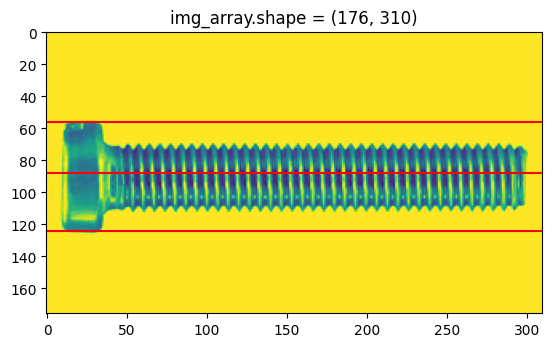

In [3]:
image = Image.open("parafuso.png").convert("L")
img_array = np.array(image)


plt.imshow(img_array)


plt.title(f"{img_array.shape = }")


plt.axhline(img_array.shape[0] // 2, color="red")


plt.axhline(img_array.shape[0] // 2 - 32, color="red")


plt.axhline(img_array.shape[0] // 2 + 36, color="red")


plt.show()

# Tentativa 1

deixando a imagem de forma binaria para encontrar as bordas.


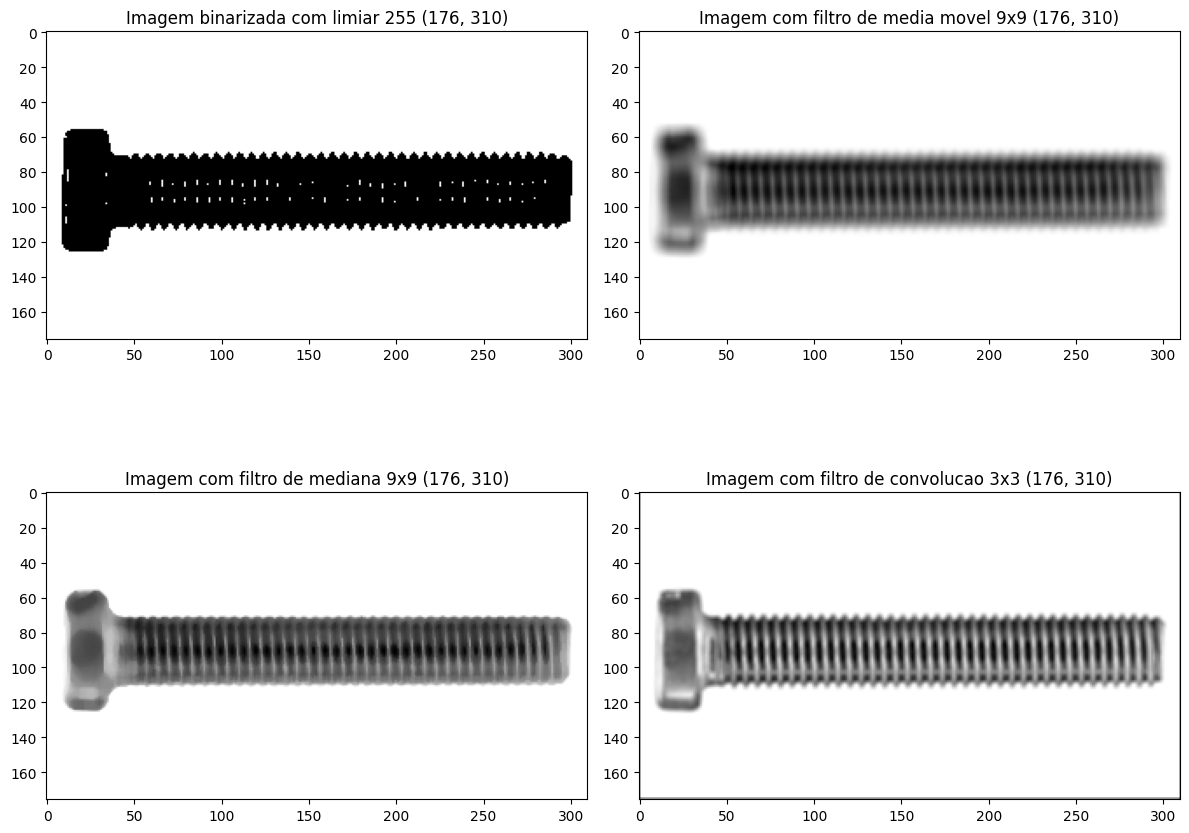

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Binarized image
img_array_1 = img_array.copy()
for i in range(img_array_1.shape[0]):
    for j in range(img_array_1.shape[1]):
        if img_array_1[i, j] < 255:
            img_array_1[i, j] = 0
        else:
            img_array_1[i, j] = 255

axs[0, 0].imshow(img_array_1, cmap="gray")
axs[0, 0].set_title(f"Imagem binarizada com limiar 255 {img_array_1.shape }")

# Moving average filter
img_array_2 = img_array.copy()
for i in range(4, img_array_2.shape[0] - 4):
    for j in range(4, img_array_2.shape[1] - 4):
        img_array_2[i, j] = np.mean(img_array[i - 4 : i + 5, j - 4 : j + 5])

axs[0, 1].imshow(img_array_2, cmap="gray")
axs[0, 1].set_title(f"Imagem com filtro de media movel 9x9 {img_array_2.shape }")

# Median filter
img_array_3 = img_array.copy()
for i in range(4, img_array_3.shape[0] - 4):
    for j in range(4, img_array_3.shape[1] - 4):
        img_array_3[i, j] = np.median(img_array[i - 4 : i + 5, j - 4 : j + 5])

axs[1, 0].imshow(img_array_3, cmap="gray")
axs[1, 0].set_title(f"Imagem com filtro de mediana 9x9 {img_array_3.shape}")

# Convolution filter
img_array_4 = img_array.copy()
kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9
img_array_4 = ndimage.convolve(img_array_4, kernel, mode="constant", cval=0.0)

axs[1, 1].imshow(img_array_4, cmap="gray")
axs[1, 1].set_title(f"Imagem com filtro de convolucao 3x3 {img_array_4.shape }")

plt.tight_layout()
plt.show()

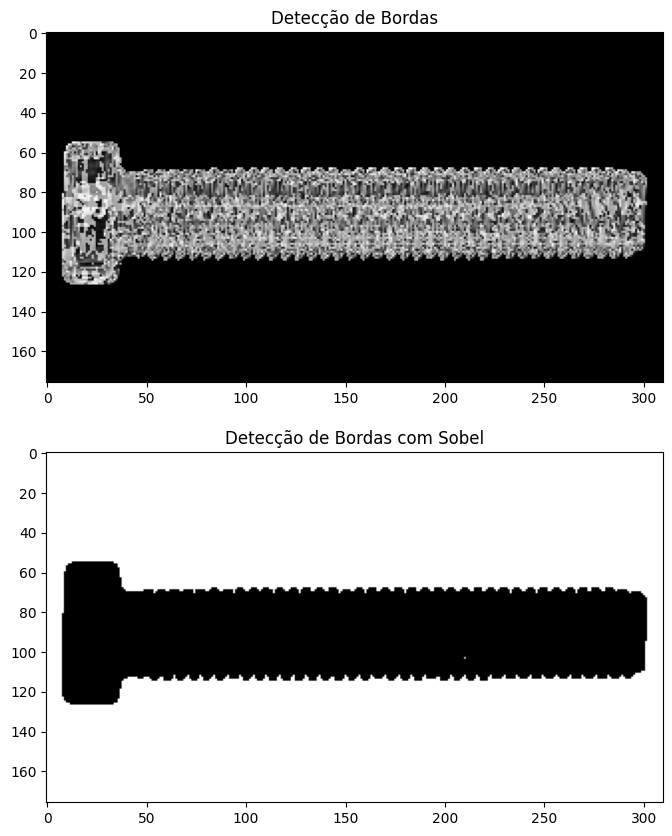

In [5]:
img_array_5 = img_array.copy()

# Aplicar detecção de bordas usando o filtro Sobel
sobel_x = ndimage.sobel(img_array_5, axis=0)
sobel_y = ndimage.sobel(img_array_5, axis=1)
edges = np.hypot(sobel_x, sobel_y)

fig, ax = plt.subplots(2, figsize=(10, 10))
ax[0].imshow(edges, cmap="gray")
ax[0].set_title("Detecção de Bordas")

for col in range(edges.shape[1]):
    if np.any(edges[:, col] > 0):
        for row in range(edges.shape[0]):
            if edges[row, col] > 0:
                img_array_5[row, col] = 0

ax[1].imshow(img_array_5, cmap="gray")
ax[1].set_title("Detecção de Bordas com Sobel")
plt.show()

In [6]:
from scipy.ndimage import uniform_filter1d

bordas = np.argwhere(edges > 0)  # Get coordinates of non-zero edge points

extremes = []
extremes_max = []
extremes_min = []

# Iterate over each x-coordinate (column)
for x in range(edges.shape[1]):
    # Get the y-values (rows) where edges exist for this specific x
    y_vals = bordas[bordas[:, 1] == x][:, 0]
    if len(y_vals) > 0:
        min_val = np.min(y_vals)  # Top edge (minimum y)
        max_val = np.max(y_vals)  # Bottom edge (maximum y)
        extremes.append((x, min_val))  # Store top edge point
        extremes.append((x, max_val))  # Store bottom edge point
        extremes_min.append((x, min_val))
        extremes_max.append((x, max_val))

extremes = np.array(extremes)  # Convert to NumPy array
extremes_max = np.array(extremes_max)
extremes_min = np.array(extremes_min)


# Moving average function
def moving_average(a, n=3):
    return uniform_filter1d(a, size=n)


mean = np.mean(moving_average(extremes[:, 1], n=5))

# Apply moving average to y-values of min and max extremes
extreme_min_moving_avg = moving_average(extremes_min[:, 1], n=10)
extreme_max_moving_avg = moving_average(extremes_max[:, 1], n=10)

print(f"Number of detected edge points: {len(extremes)}")
print(f"Mean y-value: {mean:.2f}")

filtered_extremes = extreme_max_moving_avg + extreme_min_moving_avg

Number of detected edge points: 588
Mean y-value: 90.44


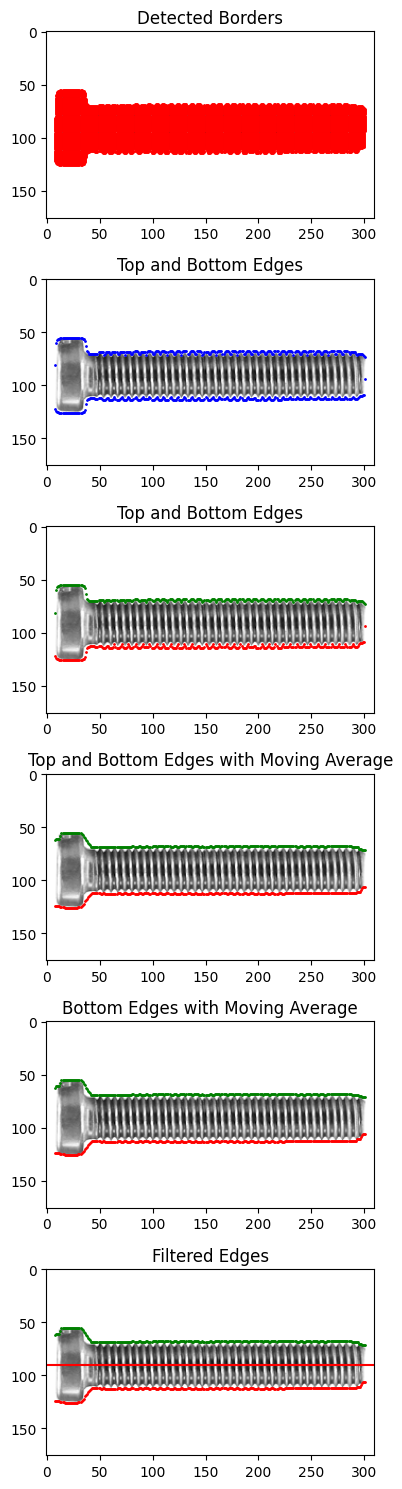

In [7]:
# Plot the original image and the detected edge points
fig, ax = plt.subplots(6, figsize=(10, 15))

ax[0].imshow(img_array, cmap="gray")
ax[0].plot(bordas[:, 1], bordas[:, 0], "ro", markersize=1)
ax[0].set_title("Detected Borders")

# Plot the extremes (top and bottom edges)
ax[1].imshow(img_array, cmap="gray")
ax[1].plot(extremes[:, 0], extremes[:, 1], "bo", markersize=1)
ax[1].set_title("Top and Bottom Edges")

ax[2].imshow(img_array, cmap="gray")
ax[2].plot(extremes_max[:, 0], extremes_max[:, 1], "ro", markersize=1)
ax[2].plot(extremes_min[:, 0], extremes_min[:, 1], "go", markersize=1)
ax[2].set_title("Top and Bottom Edges")

ax[3].imshow(img_array, cmap="gray")
ax[3].plot(extremes_max[:, 0], extreme_max_moving_avg, "ro", markersize=1)
ax[3].plot(extremes_min[:, 0], extreme_min_moving_avg, "go", markersize=1)
ax[3].set_title("Top and Bottom Edges with Moving Average")

ax[4].imshow(img_array, cmap="gray")
ax[4].plot(extremes_max[:, 0], extreme_max_moving_avg, "ro", markersize=1)
ax[4].set_title("Top Edges with Moving Average")

ax[4].imshow(img_array, cmap="gray")
ax[4].plot(extremes_min[:, 0], extreme_min_moving_avg, "go", markersize=1)
ax[4].set_title("Bottom Edges with Moving Average")

ax[5].imshow(img_array, cmap="gray")
ax[5].plot(extremes_max[:, 0], extreme_max_moving_avg, "ro", markersize=1)
ax[5].plot(extremes_min[:, 0], extreme_min_moving_avg, "go", markersize=1)
ax[5].axhline(mean, color="red")
ax[5].set_title("Filtered Edges")

plt.tight_layout()
plt.show()

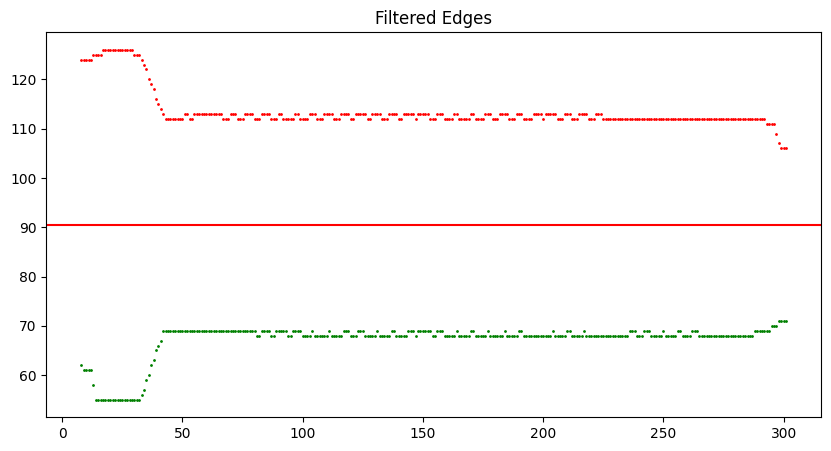

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(extremes_max[:, 0], extreme_max_moving_avg, "ro", markersize=1)
ax.plot(extremes_min[:, 0], extreme_min_moving_avg, "go", markersize=1)
ax.axhline(mean, color="red")
ax.set_title("Filtered Edges")
plt.show()

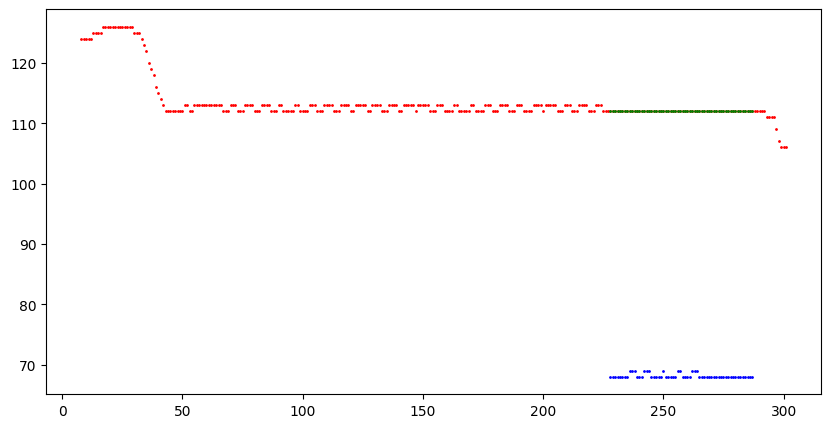

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(extremes_max[:, 0], extreme_max_moving_avg, "ro", markersize=1)
ax.plot(extremes_min[220:280, 0], extreme_max_moving_avg[220:280], "go", markersize=1)
ax.plot(extremes_min[220:280, 0], extreme_min_moving_avg[220:280], "bo", markersize=1)

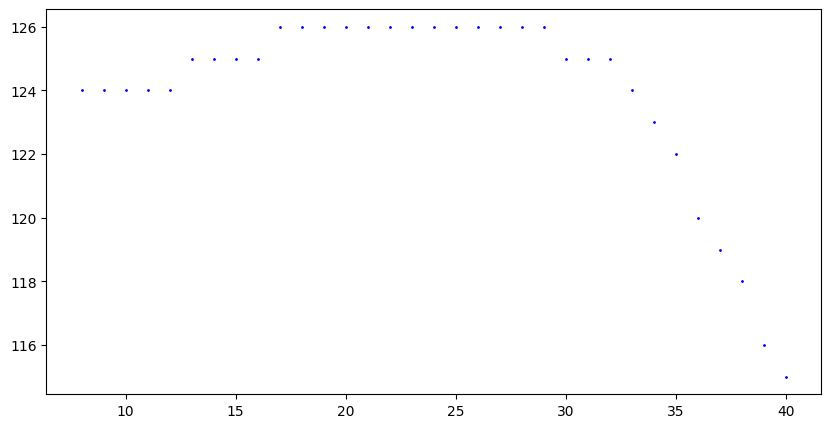

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    extremes_max[extreme_max_moving_avg > 114, 0],
    extreme_max_moving_avg[extreme_max_moving_avg > 114],
    "bo",
    markersize=1,
)

Media superior: 116.0, Max: 126, Min: 106
Media inferior: 63.0, Max: 71, Min: 55


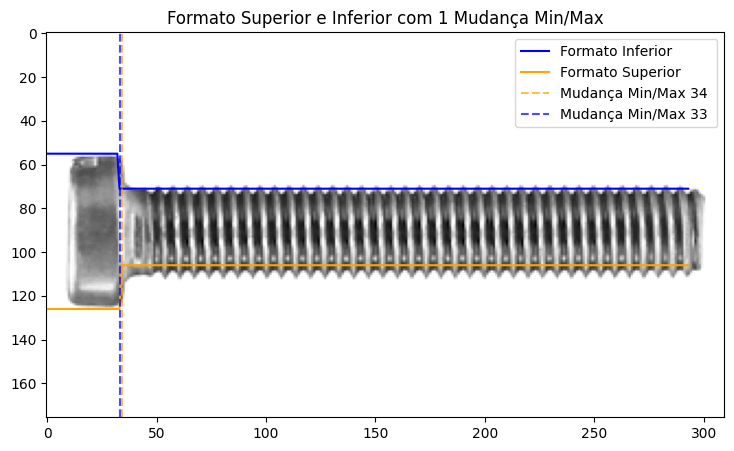

In [31]:
max_sup = extreme_max_moving_avg.max()
min_sup = extreme_max_moving_avg.min()

media_sup = (max_sup + min_sup) / 2

formato_sup = np.zeros(extreme_max_moving_avg.shape[0])

for i in range(extreme_max_moving_avg.shape[0]):
    if extreme_max_moving_avg[i] > media_sup - 3:
        formato_sup[i] = max_sup
    else:
        formato_sup[i] = min_sup

max_inf = extreme_min_moving_avg.max()
min_inf = extreme_min_moving_avg.min()

media_inf = (max_inf + min_inf) / 2

formato_inf = np.zeros(extreme_min_moving_avg.shape[0])

for i in range(extreme_min_moving_avg.shape[0]):
    if extreme_min_moving_avg[i] > media_inf + 3:
        formato_inf[i] = max_inf
    else:
        formato_inf[i] = min_inf

print(f"Media superior: {media_sup}, Max: {max_sup}, Min: {min_sup}")

print(f"Media inferior: {media_inf}, Max: {max_inf}, Min: {min_inf}")


# Function to find the first change point in an array
def find_first_change(arr):
    for i in range(1, len(arr)):
        if arr[i] != arr[i - 1]:
            return i  # Return the first index where the change occurs
    return None  # Return None if no change is found


# Get the first change point for both formato_sup and formato_inf
change_point_sup = find_first_change(formato_sup)
change_point_inf = find_first_change(formato_inf)

# Plot the formatted data and mark the change points
plt.figure(figsize=(10, 5))
plt.plot(formato_inf, label="Formato Inferior", color="blue")
plt.plot(formato_sup, label="Formato Superior", color="orange")
plt.imshow(img_array, cmap="gray")
# Draw vertical line at the change point for formato_sup, if found
if change_point_sup is not None:
    plt.axvline(
        x=change_point_sup,
        color="orange",
        linestyle="--",
        alpha=0.7,
        label=f"Mudança Min/Max {change_point_sup} ",
    )

# Draw vertical line at the change point for formato_inf, if found
if change_point_inf is not None:
    plt.axvline(
        x=change_point_inf,
        color="blue",
        linestyle="--",
        alpha=0.7,
        label=f"Mudança Min/Max {change_point_inf} ",
    )

plt.title("Formato Superior e Inferior com 1 Mudança Min/Max")
plt.legend()
plt.show()

In [152]:
media_corpo_superior = np.mean(extreme_max_moving_avg[220:280])
media_corpo_inferior = np.mean(extreme_min_moving_avg[220:280])
diametro_corpo_do_parafuso = media_corpo_superior - media_corpo_inferior

print(f"A media do diâmetro da corpo superior do parafuso = {media_corpo_superior}")
print(f"A media do diâmetro da corpo inferior do parafuso = {media_corpo_inferior}")
print(f"A media do diâmetro do corpo do parafuso = {diametro_corpo_do_parafuso}")

A media do diâmetro da corpo superior do parafuso = 112.0
A media do diâmetro da corpo inferior do parafuso = 68.2
A media do diâmetro do corpo do parafuso = 43.8


In [25]:
media_cabeca_superior = np.mean(extreme_max_moving_avg[0:25])
media_cabeca_inferior = np.mean(extreme_min_moving_avg[0:25])
diametro_cabeca_do_parafuso = media_cabeca_superior - media_cabeca_inferior

print(f"A média do diâmetro da cabeça superior do parafuso = {media_cabeca_superior}")
print(f"A média do diâmetro da cabeça inferior do parafuso = {media_cabeca_inferior}")
print(f"A média do diâmetro da cabeça do parafuso = {diametro_cabeca_do_parafuso}")

A média do diâmetro da cabeça superior do parafuso = 125.32
A média do diâmetro da cabeça inferior do parafuso = 56.36
A média do diâmetro da cabeça do parafuso = 68.96


In [29]:
# the relations beetwen the diameter of the head in pixels and the real measurement
real_diameter_head = 0.5  # cm
pixels_diameter_head = diametro_cabeca_do_parafuso  # pixels
relation_head = pixels_diameter_head / real_diameter_head

print(relation_head)  # = 138 pixels/cm

137.92
